# TUBERCOLOSIS & PNEUMONIA

Create a classifier for x-ray images:
* TB detector: classifies each image into normal, pneumonia or tubercolosis. Get a f1-score for TB > 75%
* Perform explainable AI analysis

### Input: x-ray images

### Output: N/P/T annotation for each image
* N: normal
* P: pneumonia
* T: tubercolosis

In [ ]:
# !pip install visualkeras

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import keras_tuner
#import visualkeras
import numpy as np

import os
import glob
import pathlib
import csv
import random

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import cv2
import datetime
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

from collections import Counter

In [ ]:
SEED = 99
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

### Set directories and MACRO

In [ ]:
DATA_DIR = '/kaggle/input/tbxray/train' #### da scegliere
DATA_DIR = pathlib.Path(DATA_DIR)
SAVE_DIR = '/kaggle/working'     #### da scegliere
SAVE_DIR = pathlib.Path(SAVE_DIR)
TRAINING_DIR = os.path.join(SAVE_DIR, 'Training_' + datetime.datetime.now().strftime("%Y-%m-%d-T%H:%M"))
TBOA_DIR = os.path.join(TRAINING_DIR, 'Tensorboard')
TBOARD_DIR = os.path.join(TBOA_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(TRAINING_DIR):
    os.mkdir(TRAINING_DIR)
if not os.path.exists(TBOA_DIR):
    os.mkdir(TBOA_DIR)
if not os.path.exists(TBOARD_DIR):
    os.mkdir(TBOARD_DIR)

In [ ]:
NUM_CLASSES = 3
NUM_IMAGES = 15470
IMAGE_SIZE = (400,400)
BATCH_SIZE = 16

label_df = pd.read_csv(os.path.join(DATA_DIR,"labels_train.csv"))

### First data handling
* labels
* resolutions
* train/validation/test split
* augmentation
* visualization

#### Labels

In [ ]:
# create a dictonary (couples key,value) where key=filename and value=N,P or T
im_labels_dict = {}

with open(os.path.join(DATA_DIR,"labels_train.csv"), 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        im_labels_dict[row[0]] = row[1]

im_labels_dict.pop('file')
print('Created the dictionary with elements (filename, label)')
print('-> Total elements in the dictionary: ', len(im_labels_dict))

# CREATE INT LABELS AND CATEGORICAL LABELS
im_intlabels_dict = {}
im_catlabels_dict = {}

for im_file, label in im_labels_dict.items():
    if label == 'N':
        im_intlabels_dict[im_file] = 0
        im_catlabels_dict[im_file] = tuple([1., 0., 0.])
    if label == 'P':
        im_intlabels_dict[im_file] = 1
        im_catlabels_dict[im_file] = tuple([0., 1., 0.])    
    if label == 'T':
        im_intlabels_dict[im_file] = 2
        im_catlabels_dict[im_file] = tuple([0., 0., 1.])

Created the dictionary with elements (filename, label)
-> Total elements in the dictionary:  15470


In [ ]:
# here it reads from DATA_DIR all the filenames and print the ones that are not .png nor .jpeg
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        if not filename.endswith('.png'):
            if not filename.endswith('.jpeg'):
                print(os.path.join(dirname, filename))
                
                
# printing how much .png and .jpeg images we have 
print('.png files: ', len(list(DATA_DIR.glob('*.png'))))
print('.jpeg files: ', len(list(DATA_DIR.glob('*.jpeg'))))

/kaggle/input/tbxray/train/labels_train.csv
.png files:  9621
.jpeg files:  5849


#### Resolution

In [ ]:
#GET IMAGES RESOLUTION + some checks on the images
labels_count = Counter(im_labels_dict.values())

###all the images are squared!
max_pixels = []
max_w = 0
w_mean = 0

im_size_dict = {}

for im_file, label in im_labels_dict.items():
        im = cv2.imread(os.path.join(DATA_DIR,str(im_file)),cv2.IMREAD_GRAYSCALE)
        max_pixels.append(im.max())
        w = im.shape[0]
        im_size_dict[im_file] = (w,w)
        w_mean += w
        if w > max_w:
            print('Found ',str(im_file),' with dimensions: ',im.shape)
            max_w = w
w_mean = w_mean/NUM_IMAGES
mean_imsize = (w_mean, w_mean)

print('\nTotal images number check: ', labels_count['N']+labels_count['P']+labels_count['T'])
print(NUM_IMAGES, ' ->>> ', len(max_pixels))
print('\nlabels count:\n',labels_count)

print('\nImage resolutions are listed in the dict im_size_dict')
print('->>>MEAN IMAGE SIZE:', mean_imsize)

#Convert the size dict to Dataframe and compute aspect ratio
im_meta_df = pd.DataFrame.from_dict([im_size_dict]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
im_meta_df[["Width", "Height"]] = pd.DataFrame(im_meta_df["Size"].tolist(), index=im_meta_df.index)
im_meta_df["Aspect Ratio"] = round(im_meta_df["Width"] / im_meta_df["Height"], 2)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
points = ax.scatter(im_meta_df.Width, im_meta_df.Height, color='blue', alpha=0.1, s=im_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)
print('All the images are squared')
print(f'There are {Counter(im_meta_df.Width)[400]} ({int(Counter(im_meta_df.Width)[400]/NUM_IMAGES*100)}%) images with size 400x400')
_ = plt.figure(figsize=(6, 4))
_ = plt.hist(im_meta_df.Width, bins = 20)
_ = plt.title("Image resolution histogram")
_ = plt.xlabel("Width")
_ = plt.ylabel("Occurrences")

print('---'*12)

print('\nThe maximum pixel value is contained in max_pixel list, one for each image')
print('the min value in the list is: ', min(max_pixels))
print('the max value in the list is: ', max(max_pixels))
print('->Pixel values are all in the range (0,255)')

#### Train-test-validation split

In [ ]:
images = label_df['file']
subjects = set([i[:6] for i in images])
subjects = sorted(list(subjects))

print(f'Found {len(images)} images ({NUM_IMAGES} expected) belonging to {len(subjects)} subjects; eg. first 5 named: ')
print(subjects[:5])

Found 15470 images (15470 expected) belonging to 12086 subjects; eg. first 5 named: 
['P00001', 'P00002', 'P00003', 'P00004', 'P00005']


In [ ]:
#count the images for each subject and check
nimages_for_subjects_dict = {}
no = 0
for subject in subjects:
    nimages_for_subjects_dict[subject] = 0
for image in images:
    i = image[:6]
    nimages_for_subjects_dict[i] += 1
    no += 1
#print(images_for_subjects_dict)

_ = plt.bar(nimages_for_subjects_dict.keys(), nimages_for_subjects_dict.values(), color='g')

In [ ]:
train_ratio = 0.9
test_ratio = 0.1

#####SPLIT INTO TRAIN AND TEST SUBSETS considering PATIENTS
sub_train, sub_test = train_test_split(subjects, test_size=0.1, random_state = SEED)
sub_train.sort()
sub_test.sort()
print(f'number of training subjects: {len(sub_train)}, e.g. first 10:\n {sub_train[:10]}')
print(f'number of test subjects: {len(sub_test)}, e.g. first 10:\n {sub_test[:10]}')

#print(label_df['file'])
#print(sub_train[0][:6])
im_test = []
im_train = []

for sub in sub_test:
    for im in images:
        if im[:6] == sub:
            im_test.append(im)
print('--------------------')
#print(sub_test[:10])
#print(im_test[:15])

for sub in sub_train:
    for im in images:
        if im[:6] == sub:
            im_train.append(im)
print('--------------------')
print(f'trainer pics: {len(im_train)}')
print(f'tester pics: {len(im_test)}')

### TEST DATAFRAME DEFINITION
# train_df = label_df.loc[True in label_df['file']==im for im in im_train]
train_df = label_df[label_df['file'].isin(im_train)]
train_df = train_df.reset_index()
#print(train_df)
test_df = label_df[label_df['file'].isin(im_test)]
test_df = test_df.reset_index()
#print(test_df)
#print('--------------------------')
del train_df['index']
del test_df['index']
print('TEST DATAFRAME:\n',test_df)

### COMPUTE CLASS_WEIGHTS from TRAINING SET
print('From training set:\n',train_df['label'].value_counts())

# class weights computation
classes = [0,1,2]
labels = np.array(train_df['label'])
            
unique, counts = np.unique(labels, return_counts=True)

classes_counts = dict(zip(unique,counts))                  
classes_counts['Total'] = sum(counts)
print(classes_counts)
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(labels),                # array of the classes occurring\n",
    y = np.array(labels))        #array of original class labels per sample

class_weights_dict = dict(zip(classes,class_weights))
print('class_weights_dict:\n',class_weights_dict)

number of training subjects: 10877, e.g. first 10:
 ['P00001', 'P00002', 'P00003', 'P00004', 'P00005', 'P00006', 'P00007', 'P00008', 'P00010', 'P00012']
number of test subjects: 1209, e.g. first 10:
 ['P00011', 'P00021', 'P00022', 'P00027', 'P00029', 'P00065', 'P00071', 'P00076', 'P00092', 'P00106']
--------------------
--------------------
trainer pics: 13922
tester pics: 1548
TEST DATAFRAME:
                file label
0     P00011_1.jpeg     P
1     P00011_2.jpeg     P
2      P00021_1.png     N
3     P00022_1.jpeg     P
4     P00022_2.jpeg     P
...             ...   ...
1543   P16019_1.png     T
1544   P16027_1.png     N
1545  P16040_1.jpeg     N
1546   P16057_1.png     N
1547   P16081_1.png     N

[1548 rows x 2 columns]
From training set:
 N    8407
P    3820
T    1695
Name: label, dtype: int64
{'N': 8407, 'P': 3820, 'T': 1695, 'Total': 13922}
class_weights_dict:
 {0: 0.5520003171959875, 1: 1.2148342059336823, 2: 2.7378564405113077}


#### Save validation images

In [ ]:
#SAVE VALIDATION IMAGES
x_val= []; y_val = []; caty_val = []

for im_file in val_df['file']:
        im = cv2.imread(os.path.join(DATA_DIR,str(im_file)),cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (400,400))
        im = np.expand_dims(im, axis=-1)
        im = tf.image.grayscale_to_rgb(tf.convert_to_tensor(im))
        x_val.append(im)
        y_val.append(im_labels_dict[im_file])
        caty_val.append(im_catlabels_dict[im_file])

x_val = np.array(x_val)
y_val = np.array(y_val)
inty_val = np.argmax(caty_val, axis=-1)
#caty_val = np.array(caty_val)

#### Augmentation

In [ ]:
def cutout(image, label,):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with black masks applied
    DIM = 400
    CLASSES = 3
    AUG_BATCH = BATCH_SIZE     ####

    if np.array(image).shape == (AUG_BATCH,DIM,DIM,3):
            imgs = [];
            image = np.array(image)
            for j in range(AUG_BATCH):
                # CHOOSE RANDOM LOCATION
                x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
                y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
                b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
                WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32)
                WIDTH = WIDTH//4
                ya = tf.math.maximum(0,y-WIDTH//2)
                yb = tf.math.minimum(DIM,y+WIDTH//2)
                xa = tf.math.maximum(0,x-WIDTH//2)
                xb = tf.math.minimum(DIM,x+WIDTH//2)
                # MAKE MASKED IMAGE
                image[j,ya:yb,xa:xb,:] = random.randint(0,255)
                imgs.append(np.array(image[j]))
            imgs = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
            return imgs,label
    return image, label


def transform(data_generator):
    DIM = 400
    CLASSES = 3
    AUG_BATCH = BATCH_SIZE     ####
    PROBABILITY =0.2

    for image, label in data_generator:
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32).numpy()
        if P == 1:
            image2, label = cutout(image, label)

            yield image2,label
        yield image, label

In [ ]:
train_coregen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
)

valid_coregen = tf.keras.preprocessing.image.ImageDataGenerator()

## Models

### Metrics

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras import metrics

cat_acc = metrics.CategoricalAccuracy(name="cat_acc")
recall = metrics.Recall(name="recall")

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((precision*rec)/(precision+rec+K.epsilon()))

metrics = [cat_acc, f1_m, recall, precision_m]

### Callbacks

In [ ]:
#Callback for the tensorboard monitoring
cb_tboard = tf.keras.callbacks.TensorBoard(
    log_dir=TBOARD_DIR,
    histogram_freq=1
)

# cbs for training
cb_redlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_f1_m',
    factor = 0.4,
    patience = 4,
    verbose = 1,
    mode = "max"
)

cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_f1_m',
    patience = 20,
    mode = "max",
    restore_best_weights = True)

cbs = [cb_redlr, cb_earlystop]

### CNN from scratch

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(400, 400, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
    return model

In [ ]:
model = build_model()
epochs = 55

In [ ]:
#SO WE'RE CHOOSING: O.1 PATIENTS FOR TEST, 0.1 FOR VALIDATION, 0.8 FOR TRAINING
n_folds=3
history = [] 
for k in range(n_folds):
    sub_tr, sub_valid = train_test_split(sub_train, test_size=0.286, random_state=np.random.randint(1,1000, 1)[0])
    sub_train.sort()
    sub_valid.sort()

    im_valid = []
    im_tr = []

    for sub in sub_valid:
        for im in im_train:
            if im[:6] == sub:
                im_valid.append(im)
    for sub in sub_train:
        for im in im_train:
            if im[:6] == sub:
                im_tr.append(im)
    
    tr_df = train_df[label_df['file'].isin(im_train)]
    tr_df = tr_df.reset_index()
    val_df = train_df[label_df['file'].isin(im_test)]
    val_df = val_df.reset_index()
    del tr_df['index']
    del val_df['index']
    
    model= build_model()

    train_gen = train_coregen.flow_from_dataframe(dataframe=tr_df,
                                         directory = DATA_DIR,
                                         x_col = 'file',
                                         y_col = 'label',
                                         class_mode = 'categorical',
                                         classes = [ "N" , "P" , "T" ],
                                         target_size = (400, 400),
                                         color_mode = 'grayscale',
                                         batch_size = BATCH_SIZE)
    valid_gen = valid_coregen.flow_from_dataframe(dataframe=val_df,
                                         directory = DATA_DIR,
                                         x_col = 'file',
                                         y_col = 'label',
                                         class_mode = 'categorical',
                                         classes = [ "N" , "P" , "T" ],
                                         target_size = (400, 400),
                                         color_mode = 'grayscale',
                                         batch_size = BATCH_SIZE)
    
    print("Training on Fold: ",k+1)
    history.append(model.fit(
            transform(train_gen),
            steps_per_epoch= 60,
            epochs= epochs,
            validation_data=valid_gen,
            callbacks = cbs
    ))

In [ ]:
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
plt.title('F1 scores')
for i in range(n_folds):
    plt.plot(history[i].history['f1_m'], label=str('Train F1, split'+str(i+1)), color=colors[i])
    plt.plot(history[i].history['val_f1_m'], label=str('Validation F1, split'+str(i+1)), linestyle = "dashdot",color=colors[i])
plt.legend(loc='lower right')
plt.show()

### DenseNet training (with cross-validation)

In [ ]:
input_shape = (400,400,3)

In [ ]:
supernet = tf.keras.applications.DenseNet121(include_top=False,input_shape=input_shape)
supernet.trainable = True
#supernet.summary()
#visualkeras.layered_view(supernet, legend=True, scale_xy=3)

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
def build_model():
    
    #no_neurons = 1024
    #dropout_rate = 0.2
    learning_rate = 3e-4


    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor    
    x = tf.keras.applications.densenet.preprocess_input(input_layer)
    x = supernet(x)
    x = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)
    #x = tfkl.Dropout(dropout_rate, seed=SEED)(x)

    # Classifier
    #x = tfkl.Dense(no_neurons, activation='relu')(x)

    output_layer = tfkl.Dense(3, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='model')

    opt = tf.keras.optimizers.Adam(
      learning_rate = learning_rate,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-08,
      amsgrad=False,
      name="Adam",
    )

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics, run_eagerly=True)

    return model

In [ ]:
model= build_model()
epochs = 55

#### Training 

In [ ]:
n_folds=5

#SO WE'RE CHOOSING: O.1 PATIENTS FOR TEST, 0.2 FOR VALIDATION, 0.7 FOR TRAINING
history = [] 
for k in range(n_folds):
    sub_tr, sub_valid = train_test_split(sub_train, test_size=0.286, random_state=np.random.randint(1,1000, 1)[0])
    sub_train.sort()
    sub_valid.sort()

    im_valid = []
    im_tr = []

    for sub in sub_valid:
        for im in im_train:
            if im[:6] == sub:
                im_valid.append(im)
    for sub in sub_train:
        for im in im_train:
            if im[:6] == sub:
                im_tr.append(im)
    
    tr_df = train_df[label_df['file'].isin(im_train)]
    tr_df = tr_df.reset_index()
    val_df = train_df[label_df['file'].isin(im_test)]
    val_df = val_df.reset_index()
    del tr_df['index']
    del val_df['index']
    
    model= build_model()

    train_gen = train_coregen.flow_from_dataframe(dataframe=tr_df,
                                         directory = DATA_DIR,
                                         x_col = 'file',
                                         y_col = 'label',
                                         class_mode = 'categorical',
                                         classes = [ "N" , "P" , "T" ],
                                         target_size = (400, 400),
                                         color_mode = 'rgb',
                                         batch_size = BATCH_SIZE)
    valid_gen = valid_coregen.flow_from_dataframe(dataframe=val_df,
                                         directory = DATA_DIR,
                                         x_col = 'file',
                                         y_col = 'label',
                                         class_mode = 'categorical',
                                         classes = [ "N" , "P" , "T" ],
                                         target_size = (400, 400),
                                         color_mode = 'rgb',
                                         batch_size = BATCH_SIZE)
    
    print("Training on Fold: ",k+1)
    history.append(model.fit(
            transform(train_gen),
            steps_per_epoch= 60,
            epochs= epochs,
            validation_data=valid_gen,
            callbacks = cbs
    ))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Found 12524 validated image filenames belonging to 3 classes.
Found 1398 validated image filenames belonging to 3 classes.
Training on Fold:  1


2023-01-19 14:53:38.078177: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/55


2023-01-19 14:53:39.196404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


60/60 [==============================] - 139s 2s/step - loss: 0.6268 - cat_acc: 0.7427 - f1_m: 0.6765 - recall: 0.7115 - precision_m: 0.7640 - val_loss: 1.3967 - val_cat_acc: 0.6953 - val_f1_m: 0.6885 - val_recall: 0.6831 - val_precision_m: 0.7009
Epoch 2/55
60/60 [==============================] - 126s 2s/step - loss: 0.5288 - cat_acc: 0.7937 - f1_m: 0.7864 - recall: 0.7656 - precision_m: 0.8111 - val_loss: 0.7374 - val_cat_acc: 0.7232 - val_f1_m: 0.7028 - val_recall: 0.7167 - val_precision_m: 0.7239
Epoch 3/55
60/60 [==============================] - 129s 2s/step - loss: 0.4515 - cat_acc: 0.8167 - f1_m: 0.8029 - recall: 0.7958 - precision_m: 0.8372 - val_loss: 0.9259 - val_cat_acc: 0.7325 - val_f1_m: 0.7254 - val_recall: 0.7325 - val_precision_m: 0.7332
Epoch 4/55
60/60 [==============================] - 110s 2s/step - loss: 0.5002 - cat_acc: 0.8271 - f1_m: 0.8145 - recall: 0.8135 - precision_m: 0.8355 - val_loss: 3.2857 - val_cat_acc: 0.6080 - val_f1_m: 0.5944 - val_recall: 0.6066 -

In [ ]:
#model.summary()
#visualkeras.layered_view(model, legend=True, scale_xy=1) 

In [ ]:
model.save('densenet121')

#### Training visualization

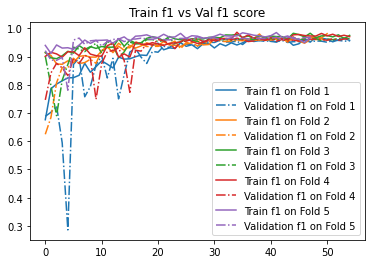

In [ ]:
colors=['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
plt.title('Train f1 vs Val f1 score')
for i in range(n_folds):
    plt.plot(history[i].history['f1_m'], label=str('Train f1 on Fold '+str(i+1)), color=colors[i])
    plt.plot(history[i].history['val_f1_m'], label=str('Validation f1 on Fold '+str(i+1)), linestyle = "dashdot",color=colors[i])
plt.legend(loc='lower right')
plt.show()

### ResNet training (with fine tuning)

In [ ]:
input_shape = (400,400,3)

supernet = tf.keras.applications.ResNet50V2(include_top=False,input_shape=input_shape)
supernet.trainable = False
#supernet.summary()
#visualkeras.layered_view(supernet, legend=True, scale_xy=3)

In [ ]:
def build_model():

    no_neurons = 1024
    dropout_rate = 0.2

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor    
    x = tf.keras.applications.resnet.preprocess_input(input_layer)
    x = supernet(x)
    x = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(x)
    x = tfkl.Dropout(rate=dropout_rate, seed=SEED, name='Dropout')(x)

    # Classifier
    x = tfkl.Dense(no_neurons, activation='relu',name='dense1',kernel_initializer=tf.keras.initializers.HeNormal)(x)
    output_layer = tfkl.Dense(3, activation='softmax', name='SoftmaxOutput',kernel_initializer=tf.keras.initializers.GlorotUniform)(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='model')

    return model

In [ ]:
model= build_model()
model.summary()

In [ ]:
epochs = 100
init_learning_rate = 1e-4

In [ ]:
opt = tf.keras.optimizers.Adam(
      learning_rate = init_learning_rate,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-08,
      amsgrad=False,
      name="Adam",
    )

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics, run_eagerly=True)

In [ ]:
history = model.fit(
        transform(train_gen),
        steps_per_epoch= 60,
        epochs= 70,
        validation_data=valid_gen,
        class_weight = class_weights_dict,
        validation_steps=60,
        callbacks = cbs
).history

In [ ]:
best_epoch = np.argmax(history['val_f1_m'])
print('Best f1_m obtained on the validation set (considering all the classes):\n',np.max(history['val_f1_m']),'reached at epoch',best_epoch)
# summarize history for f1 score
plt.figure(figsize=(17,4))
plt.plot(history['f1_m'], label='Training f1', alpha=.8, color='#ff7f0e')
plt.plot(history['val_f1_m'], label='Validation f1', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('f1 score')
plt.legend()
plt.grid(alpha=.3)
plt.show()
# summarize history for loss
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()
# summarize history for lr
plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Learning rate')
plt.grid(alpha=.3)
plt.show()

In [ ]:
supernet.trainable = True

print('->>> densenet layers')
for i,layer in enumerate(supernet.layers[:]):        
    #layer.trainable = False
    print(i,layer.name ,layer.trainable)
print('\n->>> whole network layers')
for i,layer in enumerate(model.layers[:]):
    if i != 4: 
        layer.trainable = False
    print(i,layer.name ,layer.trainable)

In [ ]:
epochs = 100
init_learning_rate = 1e-5 ####### low lr

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(init_learning_rate), 
            loss='categorical_crossentropy',
            metrics=metrics)

In [ ]:
history = model.fit(
        transform(train_gen),
        steps_per_epoch= 60,
        epochs= 70,
        validation_data=valid_gen,
        class_weight = class_weights_dict,
        validation_steps=60,
        callbacks = cbs
).history

In [ ]:
model.save('resnetv2')

## Results

### On Test set

In [ ]:
# SAVE TEST IMAGES
x_val= []; y_val = []; caty_val = []

for im_file in test_df['file']:
        im = cv2.imread(os.path.join(DATA_DIR,str(im_file)),cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (400,400))
        im = np.expand_dims(im, axis=-1)
        im = tf.image.grayscale_to_rgb(tf.convert_to_tensor(im))
        x_val.append(im)
        y_val.append(im_labels_dict[im_file])
        caty_val.append(im_catlabels_dict[im_file])

x_val = np.array(x_val)
y_val = np.array(y_val)
inty_val = np.argmax(caty_val, axis=-1)
#caty_val = np.array(caty_val)

#### Compute predictions

In [ ]:
print('validation set shape: ',x_val.shape)
print('first 5 items in y_val:\n',y_val[:5])
print('first 5 items in caty_val:\n',caty_val[:5])
print('first 5 items in inty_val:\n',inty_val[:5])


Ppreds = model.predict(x_val)
intpreds = np.argmax(Ppreds, axis=-1)
catpreds = []
preds = []
for i,pred in enumerate(intpreds):
    if pred == 0:
        preds.append('N')
        catpreds.append((1,0,0))
    if pred == 1:
        preds.append('P')
        catpreds.append((0,1,0))
    if pred == 2:
        preds.append('T')
        catpreds.append((0,0,1))
    
print('first 5 items in preds:\n',preds[:5])
print('first 5 items in catpreds:\n',catpreds[:5])
print('first 5 items in intpreds:\n',intpreds[:5])

print('---'*10)
print(f'len(y_val: {len(y_val)}')
print(f'len(preds): {len(preds)}')

validation set shape:  (1548, 400, 400, 3)
first 5 items in y_val:
 ['P' 'P' 'N' 'P' 'P']
first 5 items in caty_val:
 [(0.0, 1.0, 0.0), (0.0, 1.0, 0.0), (1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 1.0, 0.0)]
first 5 items in inty_val:
 [1 1 0 1 1]
first 5 items in preds:
 ['P', 'P', 'N', 'P', 'P']
first 5 items in catpreds:
 [(0, 1, 0), (0, 1, 0), (1, 0, 0), (0, 1, 0), (0, 1, 0)]
first 5 items in intpreds:
 [1 1 0 1 1]
------------------------------
len(y_val: 1548
len(preds): 1548


#### Visualize prediction errors

56 prediction errors out of 1548 validation images:
1) val. images n 78: T predicted N
2) val. images n 92: P predicted N
3) val. images n 93: P predicted N
4) val. images n 104: T predicted N
5) val. images n 120: P predicted N
6) val. images n 132: P predicted N
7) val. images n 153: P predicted N
8) val. images n 157: P predicted N
9) val. images n 179: N predicted P
10) val. images n 197: N predicted T
11) val. images n 199: P predicted N
12) val. images n 200: P predicted N
13) val. images n 215: T predicted N
14) val. images n 309: T predicted N
15) val. images n 316: N predicted T
16) val. images n 372: P predicted N
17) val. images n 373: P predicted N
18) val. images n 424: P predicted N
19) val. images n 445: P predicted N
20) val. images n 458: N predicted T
21) val. images n 459: N predicted T
22) val. images n 653: T predicted N
23) val. images n 757: T predicted N
24) val. images n 762: P predicted N
25) val. images n 796: N predicted T
26) val. images n 799: T predicted 

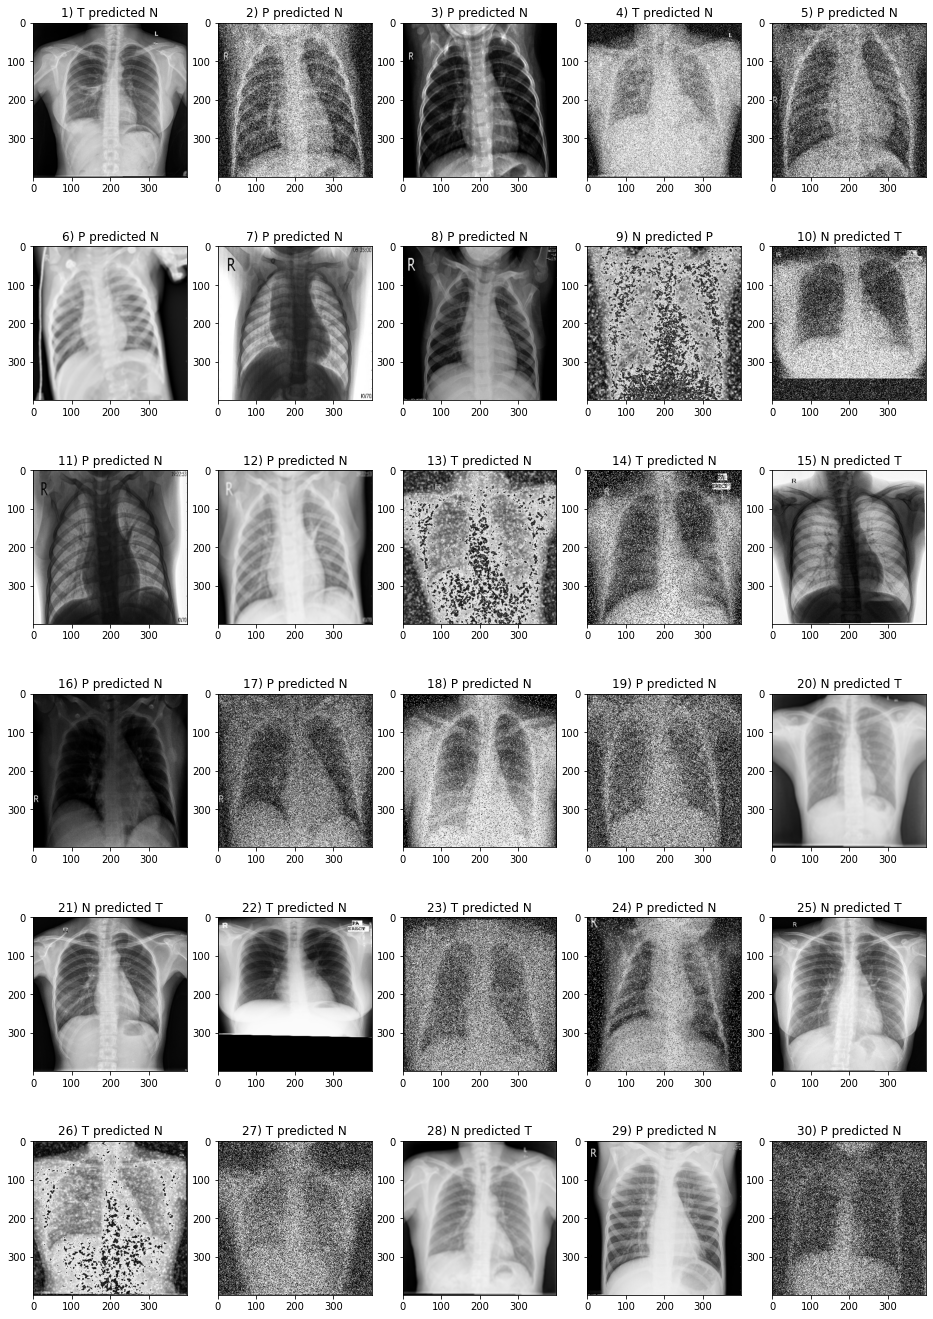

In [ ]:
pos_error=[i for i, (a,b) in enumerate(zip(inty_val, intpreds)) if a != b]
#print(pos_error)

plt.figure(figsize=(16,24))
print(len(pos_error),'prediction errors out of',len(inty_val),'validation images:')
for i,pos in enumerate(pos_error):
    if i<30:
        plt.subplot(6,5,i+1)   
        plt.title(str(i+1)+') '+str(y_val[pos])+' predicted '+str(preds[pos]))
        plt.imshow(x_val[pos])
    print(str(i+1)+') val. images n '+str(pos)+': '+str(y_val[pos])+' predicted '+str(preds[pos]))  

#### Uncertainty scores / fairness (**XAI**)

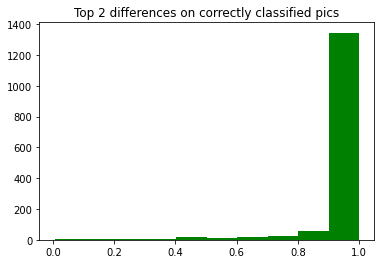

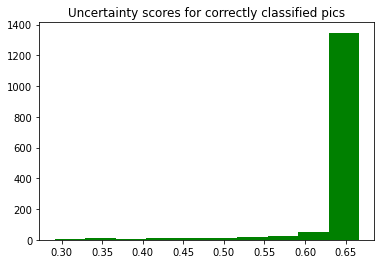

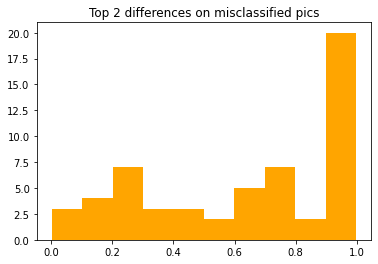

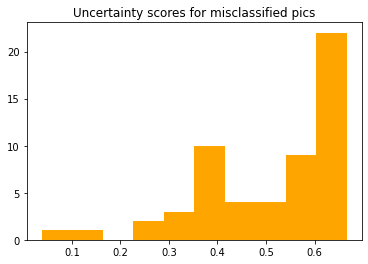

In [ ]:
pos_correct = [i for i, (a,b) in enumerate(zip(inty_val, intpreds)) if a == b]
top2diffs_ok = []
USs_ok = []
top2diffs_misclass = []
USs_misclass = []


for Ppred in Ppreds[pos_correct]:
    first = max(Ppred)
    USs_ok.append( 1- (sum(Ppred)**2)/(NUM_CLASSES*sum(y*y for y in Ppred)) )
    Ppred = np.delete(Ppred, np.where(Ppred == first))
    second = max(Ppred)
    top2diffs_ok.append(first - second)
    
for Ppred in Ppreds[pos_error]:
    first = max(Ppred)
    USs_misclass.append( 1- (sum(Ppred)**2)/(NUM_CLASSES*sum(y*y for y in Ppred)) )
    Ppred = np.delete(Ppred, np.where(Ppred == first))
    second = max(Ppred)
    top2diffs_misclass.append(first - second)
    

plt.figure()
plt.hist(top2diffs_ok, bins=10, color='g')
plt.title('Top 2 differences on correctly classified pics')

plt.figure()
plt.hist(USs_ok, bins=10, color='g')
plt.title('Uncertainty scores for correctly classified pics')


plt.figure()
plt.hist(top2diffs_misclass, bins=10, color='orange')
plt.title('Top 2 differences on misclassified pics')

plt.figure()
plt.hist(USs_misclass, bins=10, color='orange')
_=plt.title('Uncertainty scores for misclassified pics')

#### Classification report and confusion matrix

In [ ]:
print(classification_report(inty_val, intpreds))
# Precision (also called positive predictive value) is
#the fraction of relevant instances among the retrieved instances, 
# while recall (also known as sensitivity) is 
#the fraction of relevant instances that were retrieved

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       947
           1       0.99      0.95      0.97       430
           2       0.93      0.89      0.91       171

    accuracy                           0.96      1548
   macro avg       0.96      0.94      0.95      1548
weighted avg       0.96      0.96      0.96      1548



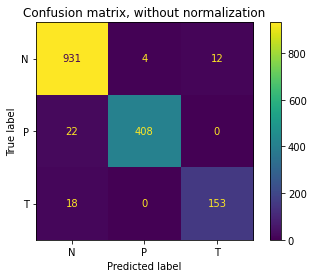

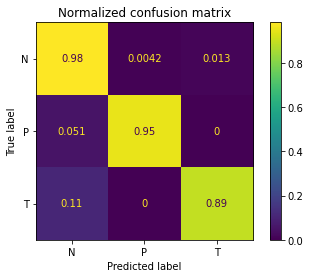

In [ ]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        inty_val,
        intpreds,
        display_labels=['N','P','T'],
        #cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    #print(title)
    #print(disp.confusion_matrix)

plt.show()

## Explainability with heatmaps

#### Background image subset definition

In [ ]:
### we're only using m images (background images) to check
m = 20

bkg_images = x_val[:m,:,:,:]
bkg_labels = y_val[:m]
bkg_catlabels = caty_val[:m]
bkg_intlabels = inty_val[:m]
bkg_Ppreds = model.predict(bkg_images)
bkg_catpreds = np.argmax(bkg_Ppreds, axis=-1)
bkg_preds = []

for i,pred in enumerate(bkg_catpreds):
    if pred == 0:
        bkg_preds.append('N')
    if pred == 1:
        bkg_preds.append('P')
    if pred == 2:
        bkg_preds.append('T')
print(f'we took {m} bkg samples from validation set, shaped {x_val.shape}')
print('background labels:\n',bkg_labels)        
print('background predictions:\n',bkg_preds)

we took 20 bkg samples from validation set, shaped (1548, 400, 400, 3)
background labels:
 ['P' 'P' 'N' 'P' 'P' 'N' 'N' 'N' 'T' 'P' 'T' 'T' 'N' 'P' 'P' 'N' 'N' 'N'
 'N' 'N']
background predictions:
 ['P', 'P', 'N', 'P', 'P', 'N', 'N', 'N', 'T', 'P', 'T', 'T', 'N', 'P', 'P', 'N', 'N', 'N', 'N', 'N']


### Gradcam
The Grad-CAM heat-map generates a coarse localization map of the important regions in the input image by using class-specific gradient information flowing into a CNN's convolutional layer (which we are interested in).

We take sections of the gradient that contribute to the prediction and reduce, resize, and rescale them so that the heat-map can be overlaid with the original image.

In [ ]:
def GradCam(model, img_array, layer, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = tf.keras.Model(
			inputs=[model.inputs],
			outputs=[layer.output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
        inputs = tf.cast(img_array, tf.float32) #we use the preprocessed image
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap,predictions


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))
def display_gradcam(img_path, heatmap):
    # Load the original image
    #img = tf.keras.preprocessing.image.load_img(img_path)
    #img = tf.keras.preprocessing.image.img_to_array(img)
    img = img_path
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))

    #heatmap = sigmoid(heatmap, 50, thresh, 1)

    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)

In [ ]:
for i, layer in enumerate(model.get_layer('densenet121').layers):
    if i>420:
        print(i, layer.name, layer.trainable)
        
for i, layer in enumerate(model.layers):
        print(i, layer.name, layer.trainable)

421 conv5_block16_1_bn True
422 conv5_block16_1_relu True
423 conv5_block16_2_conv True
424 conv5_block16_concat True
425 bn True
426 relu True
0 Input True
1 tf.math.truediv_10 True
2 tf.nn.bias_add_5 True
3 tf.math.truediv_11 True
4 densenet121 True
5 GlobalPooling True
6 dense_5 True


In [ ]:
layer = model.get_layer('densenet121').layers[-1] #'bn' # try also 'conv5_block32_concat'
img_index = 0
print(layer)

heatmap visualization without and with the mri image in background:
chosen bkg pic n0, P predicted P


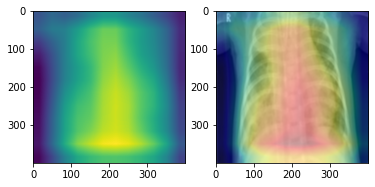

In [ ]:
print('heatmap visualization without and with the mri image in background:')
print(f'chosen bkg pic n{img_index}, {bkg_labels[img_index]} predicted {bkg_preds[img_index]}')
plt.figure()
grad_cam,predictions=GradCam(supernet,np.expand_dims(bkg_images[img_index], axis=0),layer)
plt.subplot(1,2,1)
plt.imshow(grad_cam)
#plt.colorbar()
plt.subplot(1,2,2)
display_gradcam(bkg_images[img_index], grad_cam)

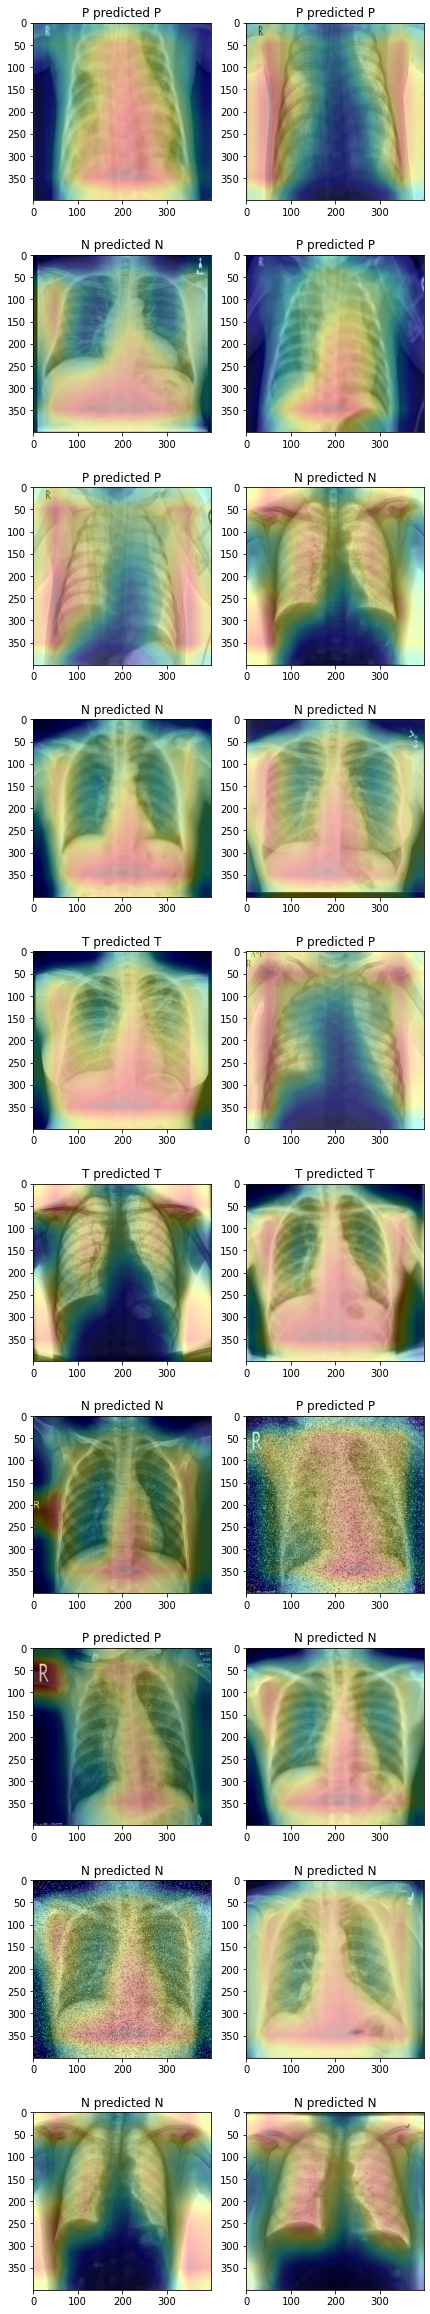

In [ ]:
###### SHOWING HEATMAPS FOR ALL THE BACKGROUND IMAGES
plt.figure(figsize=(7,42))
for i in range(20):
    grad_cam,predictions=GradCam(supernet,np.expand_dims(bkg_images[i], axis=0),layer)
    plt.subplot(10,2,i+1)
    plt.title(str(bkg_labels[i])+' predicted '+str(bkg_preds[i]))
    display_gradcam(bkg_images[i], grad_cam)

### SHAP
This is an enhanced version of the DeepLIFT algorithm (Deep SHAP) where, similar to Kernel SHAP, we approximate the conditional expectations of SHAP values using a selection of background samples. By integrating over many backgound samples Deep estimates approximate SHAP values such that they sum up to the difference between the expected model output on the passed background samples and the current model output (f(x) - E[f(x)]).

https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html

In [ ]:
import shap
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
from matplotlib.colors import LinearSegmentedColormap

# class shap.DeepExplainer(model, data, session=None, learning_phase_flags=None)

In [ ]:
img_index = 0

In [ ]:
img = bkg_images[img_index]
img_orig = image.img_to_array(img)

# segment the image so with don't have to explain every pixel
segments_slic = slic(img, n_segments=100, compactness=0.01, sigma=3) ## try compactness on a log scale

# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(mask_image(z, segments_slic, img_orig, 255))

# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=100) # runs  100 times

# get the top predictions from the model
preds = model.predict(np.expand_dims(img_orig.copy(), axis=0))
top_preds = np.argsort(-preds)

# make a color map
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)


def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

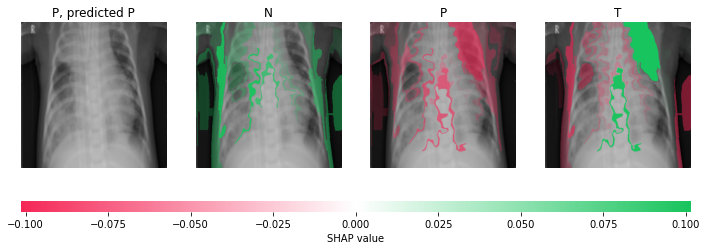

In [ ]:
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
labels = ['N','P','T']
axes[0].imshow(img)
axes[0].set_title(bkg_labels[img_index]+', predicted '+bkg_preds[img_index])
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(labels[i])
    axes[i+1].imshow(img, alpha=1) #    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

### LIME

In [ ]:
##### LIME
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

In [ ]:
img_index = 0

In [ ]:
explanation = explainer.explain_instance(bkg_images[img_index], model.predict,  
                                        num_samples=1000, random_seed=SEED)

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=15, hide_rest=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

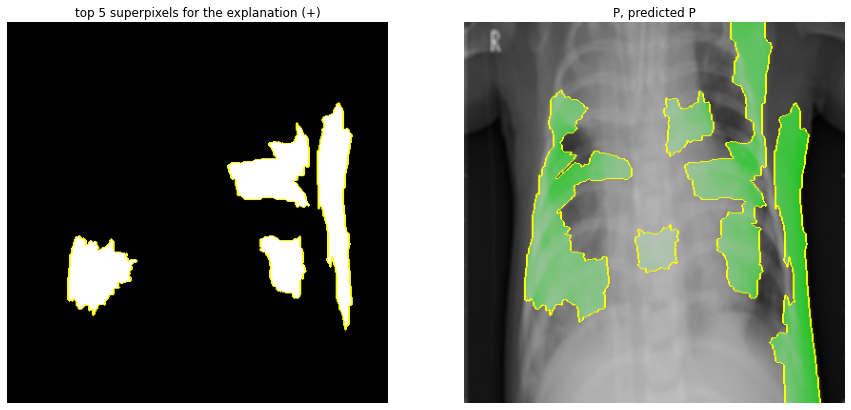

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax1.set_title(f'top 5 superpixels for the explanation (+)')
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax2.set_title(f'{bkg_labels[img_index]}, predicted {bkg_preds[img_index]}')


ax1.axis('off')
_ = ax2.axis('off')
plt.show()

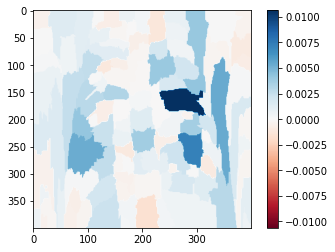

In [ ]:
#We can also form a heat-map to show how important each super-pixel is
# .. get some more granular explaianbility.
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

explanation_heatmap(explanation, explanation.top_labels[0])